In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import time

import models.lin as lin
import models.rf as rf
import models.fcnn as fcnn
import models.cnn as cnn
import data_utils.data_analysis as data_analysis

#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim

# Read the dataset

In [2]:
#READ THE DATASET
filename='galadriel_dataset.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
       shot number  order2  order3     order4
0             4731   34900  -17000 -3700000.0
1             4733   34900  -17000 -4600000.0
2             4734   34900  -17000 -4600000.0
3             4735   34900  -17000 -4600000.0
4             4736   34900  -17000 -4500000.0
...            ...     ...     ...        ...
12156        17147   35300   20000 -3800000.0
12157        17148   35300   20000 -3800000.0
12158        17149   35300   20000 -3800000.0
12159        17150   35300   20000 -3700000.0
12160        17151   35300   20000 -3700000.0

[12161 rows x 4 columns]
----
Time values
0    -94.466005
1    -83.969782
2    -73.473559
3    -62.977336
4    -52.481114
5    -41.984891
6    -31.488668
7    -20.992445
8    -10.496223
9      0.000000
10    10.496223
11    20.992445
12    31.488668
13    41.984891
14    52.481114
15    62.977336
16    73.473559
17    83.969782
18    94.466005
Name: 0, dtype: float64
----
Intensity
             0         1         2         3         

In [3]:
#Get the clean shots
maxval=65000
minval=8000
df_input_clean,df_time_clean,df_freq_int_clean=data_analysis.clean_shots_below(minval,df_input,df_time,df_freq_int)
df_input_clean,df_time_clean,df_freq_int_clean=data_analysis.clean_shots_above(maxval,df_input_clean,df_time_clean,df_freq_int_clean)


Shots with max val below this will be discarded: 8000


Shots with max val above this will be discarded: 65000



### Drop shots

In [4]:
#np.random.seed(10)
drop_factor=0.95
def drop_shots(drop_factor,df_input_clean,df_time_clean,df_freq_int_clean):
    remove_n = int(drop_factor*len(df_input_clean)) #number of shots to be dropped
    #print(remove_n)
    drop_indices = np.random.choice(df_input_clean.index, remove_n, replace=False)
    df_input_subset = df_input_clean.drop(drop_indices)
    df_time_subset = df_time_clean.drop(drop_indices)
    df_freq_int_subset = df_freq_int_clean.drop(drop_indices)
    #print(df_input_subset)
    #print(df_time_subset)
    print('The datasize is no: '+str(len(df_time_subset)))
    return df_input_subset,df_time_subset,df_freq_int_subset

In [5]:
drop_factor=0.95
df_input_subset,df_time_subset,df_freq_int_subset=drop_shots(drop_factor,df_input_clean,df_time_clean,df_freq_int_clean)

The datasize is no: 608


### Define the inputs and targets

In [6]:
#define input and output for the model

#In this notebook, the two models (forward and backward) are trained.
#we keep the same X and y. Note that in the backward model the X  and y need to be switched.
X=df_input_subset[['order2','order3','order4']]
y=df_time_subset

In [7]:
#split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=101)

In [8]:
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

## Train a forward model with linear function

In [9]:
lin_model_forward=lin.fit_lin_model(X_train,y_train)
y_predict_lin_forward=lin.make_lin_prediction(lin_model_forward,X_test)

## Train the forward model with Random forest

In [10]:
n_estimators = 300
max_features = 'sqrt'
max_depth=20
random_state=18

rf_model_forward=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state)
y_predict_forest_forward=rf.make_rf_prediction(rf_model_forward,X_test)

## Train a backward model with linear function

In [11]:
lin_model_backward=lin.fit_lin_model(y_train,X_train)
X_predict_lin_backward=lin.make_lin_prediction(lin_model_backward,y_test)

## Train the backward model with the Random forest

In [12]:
n_estimators = 300
max_features = 'sqrt'
max_depth=20
random_state=18

rf_model_backward=rf.fit_random_forest(y_train,X_train,n_estimators, max_features,max_depth, random_state)
X_predict_forest_backward=rf.make_rf_prediction(rf_model_backward,y_test)


## Train the backward model with a Fully connected NN

In [13]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cpu


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [14]:
n_epochs=200
batch_size=20
print_freq=10
learning_rate=0.001

nn_fc_model = fcnn.fit_fc_nn(X_train,y_train,X_test,y_test,
              n_epochs,batch_size,print_freq,learning_rate)
X_predict_fc_nn=fcnn.make_fc_nn_prediction(nn_fc_model,y_test,X_train,device)

We are using: cpu
Finished epoch 0,latest loss 1.0538731813430786
Finished epoch 10,latest loss 0.8409377932548523
Finished epoch 20,latest loss 0.6951643228530884
Finished epoch 30,latest loss 0.6823934316635132
Finished epoch 40,latest loss 0.6710763573646545
Finished epoch 50,latest loss 0.66173255443573
Finished epoch 60,latest loss 0.6542344689369202
Finished epoch 70,latest loss 0.6468497514724731
Finished epoch 80,latest loss 0.6389431953430176
Finished epoch 90,latest loss 0.6296514868736267
Finished epoch 100,latest loss 0.6176618933677673
Finished epoch 110,latest loss 0.5712417364120483
Finished epoch 120,latest loss 0.5397824645042419
Finished epoch 130,latest loss 0.5206109881401062
Finished epoch 140,latest loss 0.500358521938324
Finished epoch 150,latest loss 0.48231878876686096
Finished epoch 160,latest loss 0.4663918912410736
Finished epoch 170,latest loss 0.45654332637786865
Finished epoch 180,latest loss 0.44378048181533813
Finished epoch 190,latest loss 0.4354860782

## Train the backward model with a CNN

In [15]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cpu


In [16]:
n_epochs=200
batch_size=20
print_freq=10
learning_rate=0.001

cnn_model = cnn.fit_cnn(X_train,y_train,X_test,y_test,
              n_epochs,batch_size,print_freq,learning_rate)
X_predict_cnn=cnn.make_cnn_prediction(cnn_model,y_test,X_train,device)

We are using: cpu
Finished epoch 0,latest loss 1.0419398546218872
Finished epoch 10,latest loss 0.8049890995025635
Finished epoch 20,latest loss 0.7428357601165771
Finished epoch 30,latest loss 0.6997585296630859
Finished epoch 40,latest loss 0.6029397249221802
Finished epoch 50,latest loss 0.5697399973869324
Finished epoch 60,latest loss 0.5549014210700989
Finished epoch 70,latest loss 0.5445707440376282
Finished epoch 80,latest loss 0.5364828109741211
Finished epoch 90,latest loss 0.5319554805755615
Finished epoch 100,latest loss 0.5208960175514221
Finished epoch 110,latest loss 0.5135142803192139
Finished epoch 120,latest loss 0.516285240650177
Finished epoch 130,latest loss 0.5083937048912048
Finished epoch 140,latest loss 0.4984186589717865
Finished epoch 150,latest loss 0.5059751272201538
Finished epoch 160,latest loss 0.5078548789024353
Finished epoch 170,latest loss 0.4856899082660675
Finished epoch 180,latest loss 0.4961833655834198
Finished epoch 190,latest loss 0.49249124526

## ROUNDTRIP: Predict pulse shape from predictions in the backward model

In [17]:
#linear model
y_predict_lin_backforw=lin_model_forward.predict(X_predict_lin_backward)
#random forest
y_predict_backforw=rf_model_forward.predict(X_predict_forest_backward)
#FC NN (using RF as forward)
y_predict_fcnn_backforw=rf_model_forward.predict(X_predict_fc_nn)
#CNN (using RF as forward
y_predict_cnn_backforw=rf_model_forward.predict(X_predict_cnn)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [18]:
def plot_example(shot_index,y_test,y_test_reset,df_input_subset,df_time_val,
                 y_predict_lin_backforw,y_predict_backforw,y_predict_fcnn_backforw,y_predict_cnn_backforw):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=data_analysis.get_shot_num(shot_index,y_test,df_input_subset)
    
    plt.plot(df_time_val,y_test_reset.loc[shot_index],label='Test (shot #'+str(shot_numb)+')')
    plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
    plt.plot(df_time_val,y_predict_backforw[shot_index],label='Prediction (Random  forest)')
    plt.plot(df_time_val,y_predict_fcnn_backforw[shot_index],label='Prediction (FC NN)')
    plt.plot(df_time_val,y_predict_cnn_backforw[shot_index],label='Prediction (CNN)')

    mae='{:6.5f}'.format(mean_absolute_error(y_test_reset.loc[shot_index],y_predict_lin_backforw[shot_index]))
    #plt.title('Mean abs. error:'+mae)
    plt.xlabel('Time(fs)')
    plt.ylabel('Intensity')
    plt.legend()

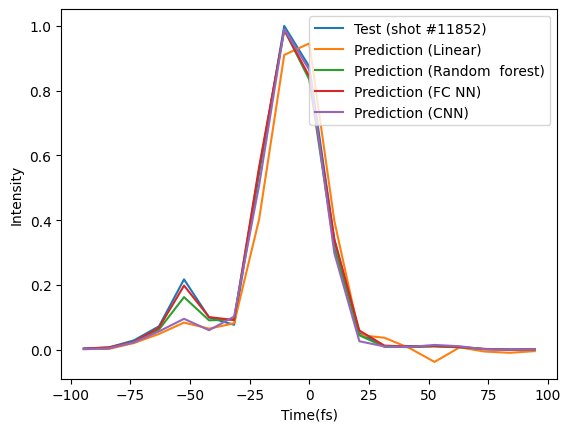

In [19]:
plot_example(25,y_test,y_test_reset,df_input_subset,df_time_val,
             y_predict_lin_backforw,y_predict_backforw,y_predict_fcnn_backforw,y_predict_cnn_backforw)

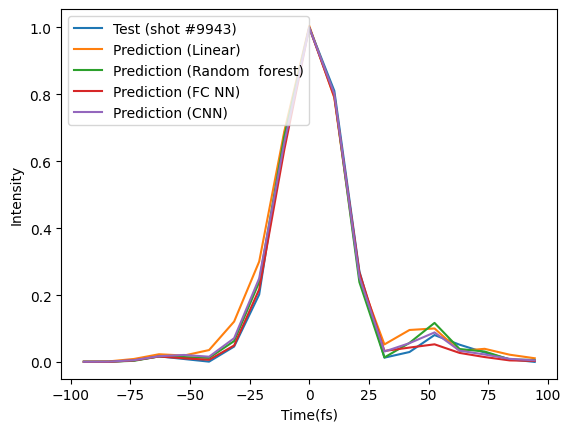

In [20]:
plot_example(5,y_test,y_test_reset,df_input_subset,df_time_val,
             y_predict_lin_backforw,y_predict_backforw,y_predict_fcnn_backforw,y_predict_cnn_backforw)

## Error distribution

### linear model

In [21]:
#study the erro distribution
df_error_backforw_lin=abs(y_test_reset-y_predict_lin_backforw)
df_error_backforw_lin=df_error_backforw_lin.sum(axis=1)/y_test.shape[1] #sum error / num columns
print(df_error_backforw_lin)

print(df_error_backforw_lin.idxmax())
print(df_error_backforw_lin.max())

0      0.039238
1      0.028499
2      0.031594
3      0.048225
4      0.030714
         ...   
178    0.027312
179    0.029566
180    0.024389
181    0.025073
182    0.017667
Length: 183, dtype: float64
168
0.0732046794951673


### random forest

In [22]:
#study the erro distribution
df_error_backforw_forest=abs(y_test_reset-y_predict_backforw)
df_error_backforw_forest=df_error_backforw_forest.sum(axis=1)/y_test.shape[1] #sum error / num columns
print(df_error_backforw_forest)

print(df_error_backforw_forest.idxmax())
print(df_error_backforw_forest.max())

0      0.041282
1      0.021822
2      0.016451
3      0.026718
4      0.012303
         ...   
178    0.013320
179    0.021606
180    0.018529
181    0.016092
182    0.019135
Length: 183, dtype: float64
168
0.09372395421052646


### FC NN

In [23]:
#study the erro distribution
df_error_backforw_fcnn=abs(y_test_reset-y_predict_fcnn_backforw)
df_error_backforw_fcnn=df_error_backforw_fcnn.sum(axis=1)/y_test.shape[1] #sum error / num columns
print(df_error_backforw_fcnn)

print(df_error_backforw_fcnn.idxmax())
print(df_error_backforw_fcnn.max())

0      0.014442
1      0.047911
2      0.014461
3      0.026718
4      0.019290
         ...   
178    0.013191
179    0.019996
180    0.012958
181    0.022509
182    0.020802
Length: 183, dtype: float64
41
0.0765943782456141


### CNN

In [24]:
#study the erro distribution
df_error_backforw_cnn=abs(y_test_reset-y_predict_cnn_backforw)
df_error_backforw_cnn=df_error_backforw_cnn.sum(axis=1)/y_test.shape[1] #sum error / num columns
print(df_error_backforw_cnn)

print(df_error_backforw_cnn.idxmax())
print(df_error_backforw_cnn.max())

0      0.039371
1      0.009985
2      0.012518
3      0.017281
4      0.017025
         ...   
178    0.019479
179    0.025331
180    0.014265
181    0.018147
182    0.039210
Length: 183, dtype: float64
168
0.08795362315789505


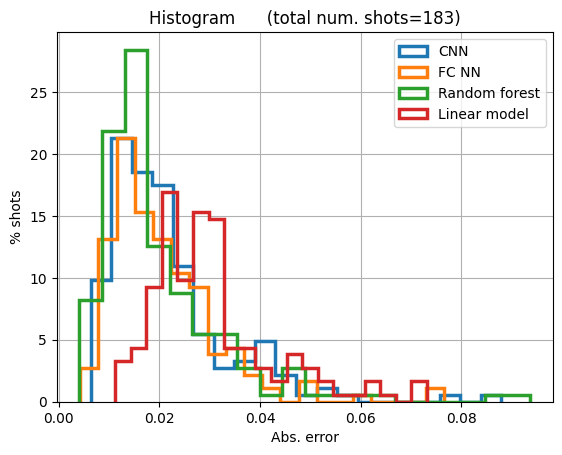

In [25]:
weights_backforw_cnn = 100*np.ones_like(df_error_backforw_cnn) / len(df_error_backforw_cnn)
weights_backforw_fcnn = 100*np.ones_like(df_error_backforw_fcnn) / len(df_error_backforw_fcnn)
weights_backforw_forest = 100*np.ones_like(df_error_backforw_forest) / len(df_error_backforw_forest)
weights_backforw_lin = 100*np.ones_like(df_error_backforw_lin) / len(df_error_backforw_lin)
df_error_backforw_cnn.hist(bins=20,weights=weights_backforw_cnn,histtype="step",linewidth=2.5,label='CNN')
df_error_backforw_fcnn.hist(bins=20,weights=weights_backforw_fcnn,histtype="step",linewidth=2.5,label='FC NN')
df_error_backforw_forest.hist(bins=20,weights=weights_backforw_forest,histtype="step",linewidth=2.5,label='Random forest')
df_error_backforw_lin.hist(bins=20,weights=weights_backforw_lin,histtype="step",linewidth=2.5, label='Linear model')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Histogram      (total num. shots='+str(len(df_error_backforw_forest))+')')
plt.legend()

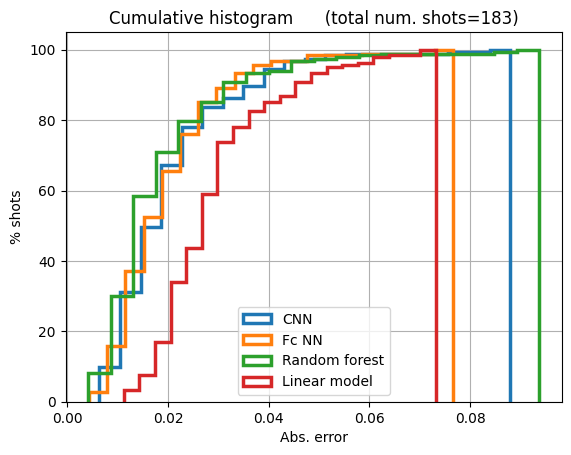

The average error in the CNN is 2.16%
The average error in the FC NN is 2.05%
The average error in the Random forest is 2.00%
The average error in the linear model is 3.02%
 
 


In [26]:
weights_backforw_cnn = 100*np.ones_like(df_error_backforw_cnn) / len(df_error_backforw_cnn)
weights_backforw_fcnn = 100*np.ones_like(df_error_backforw_fcnn) / len(df_error_backforw_fcnn)
weights_backforw_forest = 100*np.ones_like(df_error_backforw_forest) / len(df_error_backforw_forest)
weights_backforw_lin = 100*np.ones_like(df_error_backforw_lin) / len(df_error_backforw_lin)
df_error_backforw_cnn.hist(bins=20,weights=weights_backforw_cnn,cumulative=True,histtype="step",linewidth=2.5,label='CNN')
df_error_backforw_fcnn.hist(bins=20,weights=weights_backforw_fcnn,cumulative=True,histtype="step",linewidth=2.5,label='Fc NN')
df_error_backforw_forest.hist(bins=20,weights=weights_backforw_forest,cumulative=True,histtype="step",linewidth=2.5,label='Random forest')
df_error_backforw_lin.hist(bins=20,weights=weights_backforw_lin,cumulative=True,histtype="step",linewidth=2.5, label='Linear model')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Cumulative histogram      (total num. shots='+str(len(df_error_backforw_forest))+')')
plt.legend()
plt.show()

avg_error_cnn=100*df_error_backforw_cnn.mean()
avg_error_fcnn=100*df_error_backforw_fcnn.mean()
avg_error_forest=100*df_error_backforw_forest.mean()
avg_error_lin=100*df_error_backforw_lin.mean()
print('The average error in the CNN is {:4.2f}%'.format(avg_error_cnn))
print('The average error in the FC NN is {:4.2f}%'.format(avg_error_fcnn))
print('The average error in the Random forest is {:4.2f}%'.format(avg_error_forest))
print('The average error in the linear model is {:4.2f}%'.format(avg_error_lin))
print(' ')
print(' ')

## Error distribution in the parameter space

We want to see if there is any correlation between the largest error shots and its parameters

In [27]:
temp_error_forest=df_error_backforw_forest.copy()
temp_error_forest.to_frame()
temp_error_forest=temp_error_forest.set_axis(y_test.index)
print(temp_error_forest)
df_error_distr=X_test.copy()
df_error_distr['error prediction']=temp_error_forest
df_error_distr=df_error_distr[df_error_distr['error prediction']>0.02]
df_error_distr

11789    0.041282
5862     0.021822
897      0.016451
1413     0.026718
10449    0.012303
           ...   
8151     0.013320
7586     0.021606
9199     0.018529
2090     0.016092
174      0.019135
Length: 183, dtype: float64


,order2,order3,order4,error prediction
11789,35300,8000,-3800000.0,0.041282
5862,35100,-5000,-3700000.0,0.021822
1413,34950,-16000,-4100000.0,0.026718
11610,35300,2000,-3700000.0,0.025718
11509,35300,-1000,-4100000.0,0.029156
...,...,...,...,...
10687,35250,19000,-4600000.0,0.093724
148,34900,-12000,-4600000.0,0.033931
8565,35200,-6000,-4600000.0,0.026443
2941,35000,-10000,-4500000.0,0.029949


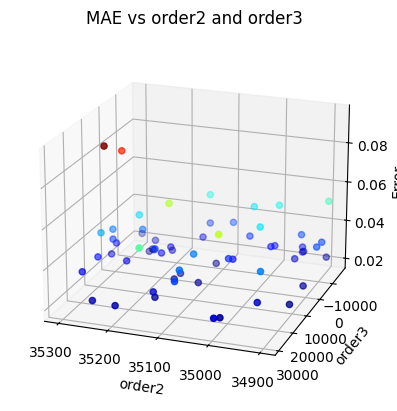

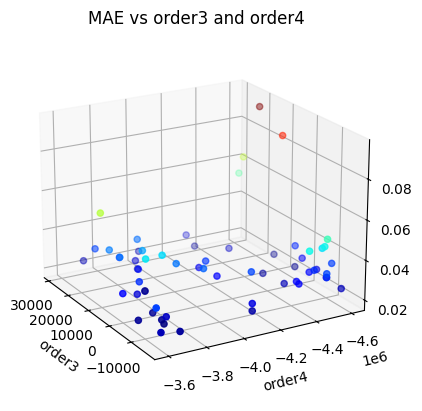

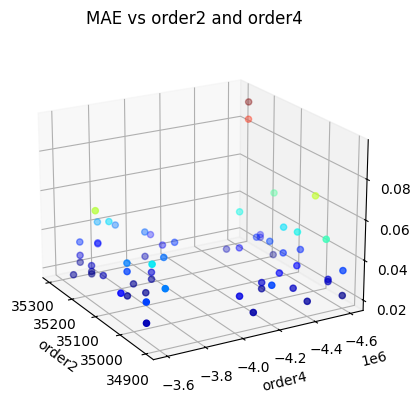

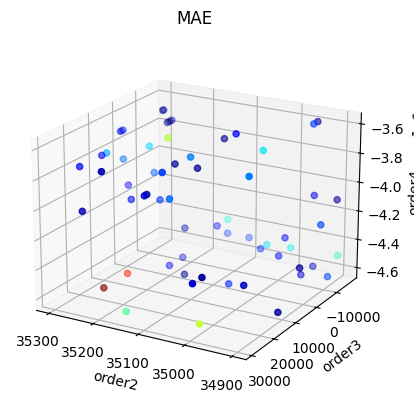

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_error_distr['order2'], df_error_distr['order3'], df_error_distr['error prediction'],c=df_error_distr['error prediction'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('Error')
ax.view_init(elev=20., azim=110)
plt.title('MAE vs order2 and order3')
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df_error_distr['order3'], df_error_distr['order4'], df_error_distr['error prediction'],c=df_error_distr['error prediction'],cmap='jet')
ax2.set_xlabel('order3')
ax2.set_ylabel('order4')
ax2.set_zlabel('Error')
ax2.view_init(elev=20., azim=150)
plt.title('MAE vs order3 and order4')
plt.show()

fig = plt.figure()
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df_error_distr['order2'], df_error_distr['order4'], df_error_distr['error prediction'],c=df_error_distr['error prediction'],cmap='jet')
ax3.set_xlabel('order2')
ax3.set_ylabel('order4')
ax3.set_zlabel('Error')
ax3.view_init(elev=20., azim=150)
plt.title('MAE vs order2 and order4')
plt.show()

fig = plt.figure()
ax4 = fig.add_subplot(projection='3d')
ax4.scatter(df_error_distr['order2'], df_error_distr['order3'], df_error_distr['order4'],c=df_error_distr['error prediction'],cmap='jet')
ax4.set_xlabel('order2')
ax4.set_ylabel('order3')
ax4.set_zlabel('order4')
ax4.view_init(elev=20., azim=120)
plt.title('MAE')
#plt.tight_layout()
plt.show()

## Test shots (Apr 12)

In [29]:
#X are dazzler param, y is intensity

In [30]:
def plot_test_shot_and_predictions(y_test_shot):
    ###  random forest
    X_predict_shot_forest=rf_model_backward.predict(y_test_shot) #backward prediction
    y_predict_shot_forest=rf_model_forward.predict(X_predict_shot_forest) #forward prediction
    #print(y_predict_shot0)

    ###  FCNN
    #first convert to tensor
    y_test_shot_tensor=torch.tensor(y_test_shot)#.values,dtype=torch.float32)
    y_test_shot_tensor=y_test_shot_tensor.to(device)
    
    X_predict_shot_fcnn_tensor=nn_fc_model(y_test_shot_tensor)
    X_predict_shot_fcnn_reg=X_predict_shot_fcnn_tensor.detach().cpu().numpy()
    #Revert the target normalization
    X_predict_shot_fcnn=X_predict_shot_fcnn_reg.copy()
    X_predict_shot_fcnn[:,0]=(X_predict_shot_fcnn_reg[:,0]*X_train['order2'].std())+X_train['order2'].mean()
    X_predict_shot_fcnn[:,1]=(X_predict_shot_fcnn_reg[:,1]*X_train['order3'].std())+X_train['order3'].mean()
    X_predict_shot_fcnn[:,2]=(X_predict_shot_fcnn_reg[:,2]*X_train['order4'].std())+X_train['order4'].mean()
    y_predict_shot_fcnn=rf_model_forward.predict(X_predict_shot_fcnn) #forward prediction

    ### CNN
    X_predict_shot_cnn_tensor=cnn_model(y_test_shot_tensor.unsqueeze(1))
    X_predict_shot_cnn_reg=X_predict_shot_cnn_tensor.detach().cpu().numpy()
    #Revert the target normalization
    X_predict_shot_cnn=X_predict_shot_cnn_reg.copy()
    X_predict_shot_cnn[:,0]=(X_predict_shot_cnn_reg[:,0]*X_train['order2'].std())+X_train['order2'].mean()
    X_predict_shot_cnn[:,1]=(X_predict_shot_cnn_reg[:,1]*X_train['order3'].std())+X_train['order3'].mean()
    X_predict_shot_cnn[:,2]=(X_predict_shot_cnn_reg[:,2]*X_train['order4'].std())+X_train['order4'].mean()
    y_predict_shot_cnn=rf_model_forward.predict(X_predict_shot_cnn) #forward prediction


    plt.plot(df_time_val,y_test_shot[0],label='Test shot')
    plt.plot(df_time_val,y_predict_shot_forest[0],label='Prediction round-trip RF')
    plt.plot(df_time_val,y_predict_shot_fcnn[0],label='Prediction round-trip FC NN')
    plt.plot(df_time_val,y_predict_shot_cnn[0],label='Prediction round-trip CNN')
    mae='{:6.5f}'.format(mean_absolute_error(y_test_shot,y_predict_shot_forest))
    #plt.title('Mean abs. error:'+mae)
    plt.xlabel('Time(fs)')
    plt.ylabel('Intensity')
    plt.legend()

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


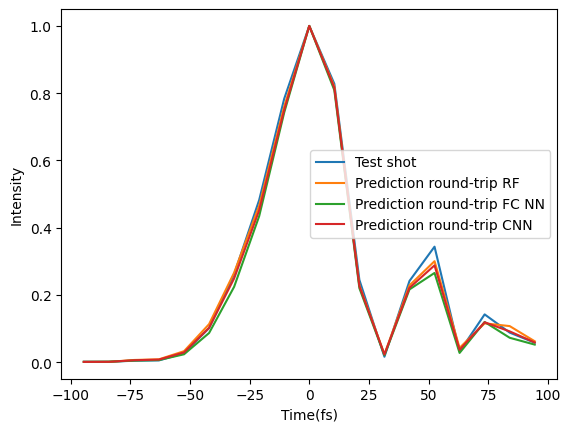

In [31]:
#shot0
y_test_shot0=[[0.001199,0.00104,0.004285,0.005213,0.026507,0.101424,0.261314,0.482225,0.783666,1.0,0.82783,0.244637,0.016048,0.241497,0.34343,0.031268,0.142042,0.087892,0.057908]]
plot_test_shot_and_predictions(y_test_shot0)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


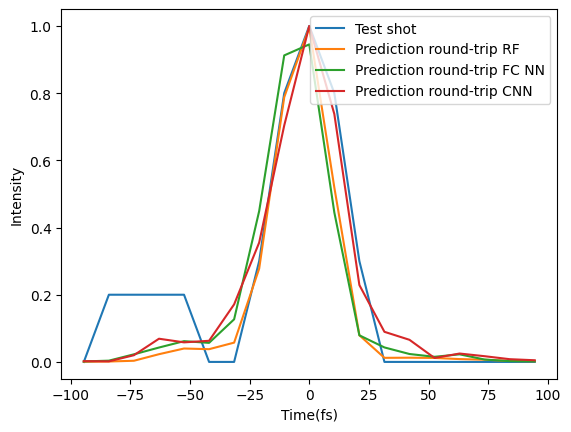

In [32]:
#shot1
y_test_shot1=[[0,0.2,0.2,0.2,0.2,0,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
plot_test_shot_and_predictions(y_test_shot1)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


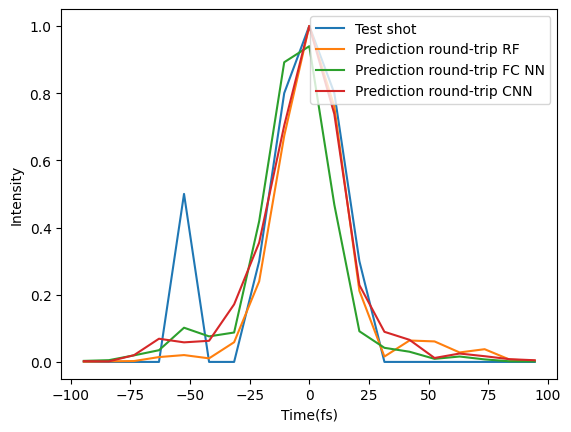

In [33]:
#shot2
y_test_shot2=[[0,0,0,0,0.5,0,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
plot_test_shot_and_predictions(y_test_shot2)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


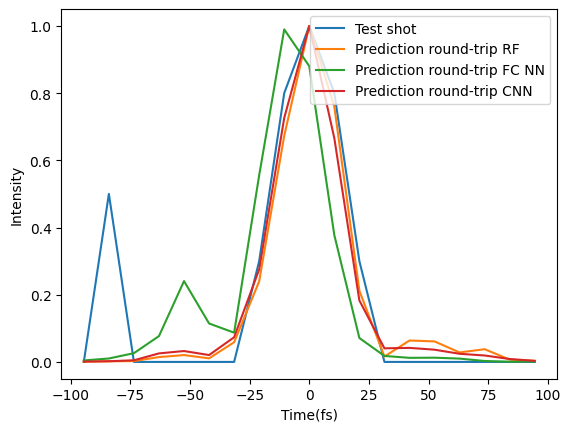

In [34]:
#shot3
y_test_shot3=[[0,0.5,0,0,0,0,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
plot_test_shot_and_predictions(y_test_shot3)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


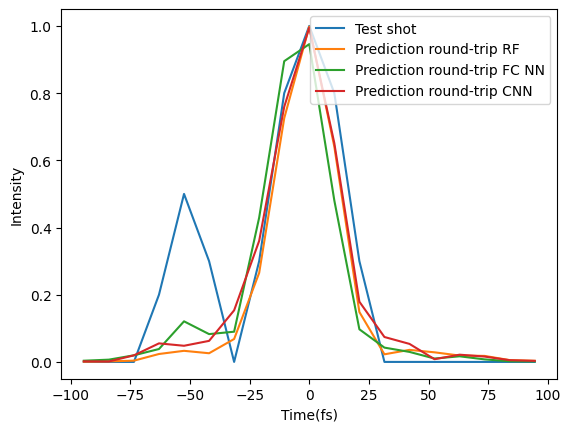

In [35]:
#shot4 (checking myself
y_test_shot4=[[0,0,0,0.2,0.5,0.3,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
plot_test_shot_and_predictions(y_test_shot4)

# CHECK MODEL WITH DIFFERENT SIZES

In [41]:
def train_model(df_input_subset,df_time_subset):
    #define input and output for the model
    X=df_input_subset[['order2','order3','order4']]
    y=df_time_subset
    #split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=101)
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 'sqrt'
    max_depth=20
    random_state=18
    rf_model_forward=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state)
    y_predict_forest_forward=rf.make_rf_prediction(rf_model_forward,X_test)

    #train backward model with RF
    rf_model_backward=rf.fit_random_forest(y_train,X_train,n_estimators, max_features,max_depth, random_state)
    X_predict_forest_backward=rf.make_rf_prediction(rf_model_backward,y_test)

    #roundtrip prediction
    y_predict_backforw=rf_model_forward.predict(X_predict_forest_backward)
    
    #study the erro distribution
    df_error_backforw_forest=abs(y_test_reset-y_predict_backforw)
    df_error_backforw_forest=df_error_backforw_forest.sum(axis=1)/y_test.shape[1] #sum error / num columns
    #print(df_error_backforw_forest)

    #print(df_error_backforw_forest.idxmax())
    #print(df_error_backforw_forest.max())
    return df_error_backforw_forest

In [64]:
drop_factor=0.00
df_input_subset_12k,df_time_subset_12k,df_freq_int_subset_12k=drop_shots(drop_factor,df_input_clean,df_time_clean,df_freq_int_clean)

drop_factor=0.50
df_input_subset_6k,df_time_subset_6k,df_freq_int_subset_6k=drop_shots(drop_factor,df_input_clean,df_time_clean,df_freq_int_clean)

drop_factor=0.70
df_input_subset_3k,df_time_subset_3k,df_freq_int_subset_3k=drop_shots(drop_factor,df_input_clean,df_time_clean,df_freq_int_clean)

drop_factor=0.90
df_input_subset_1200,df_time_subset_1200,df_freq_int_subset_1200=drop_shots(drop_factor,df_input_clean,df_time_clean,df_freq_int_clean)

drop_factor=0.95
df_input_subset_600,df_time_subset_600,df_freq_int_subset_600=drop_shots(drop_factor,df_input_clean,df_time_clean,df_freq_int_clean)

drop_factor=0.975
df_input_subset_300,df_time_subset_300,df_freq_int_subset_300=drop_shots(drop_factor,df_input_clean,df_time_clean,df_freq_int_clean)

The datasize is no: 12150
The datasize is no: 6075
The datasize is no: 3645
The datasize is no: 1215
The datasize is no: 608
The datasize is no: 304


In [65]:
#TRAIN THE MODELS
#12000 dataset
df_error_roundtrip_12k=train_model(df_input_subset_12k,df_time_subset_12k)

#6000 dataset
df_error_roundtrip_6k=train_model(df_input_subset_6k,df_time_subset_6k)

#3600 dataset
df_error_roundtrip_3k=train_model(df_input_subset_3k,df_time_subset_3k)

#1200 dataset
df_error_roundtrip_1200=train_model(df_input_subset_1200,df_time_subset_1200)

#600 dataset
df_error_roundtrip_600=train_model(df_input_subset_600,df_time_subset_600)

#300 dataset
df_error_roundtrip_300=train_model(df_input_subset_300,df_time_subset_300)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  

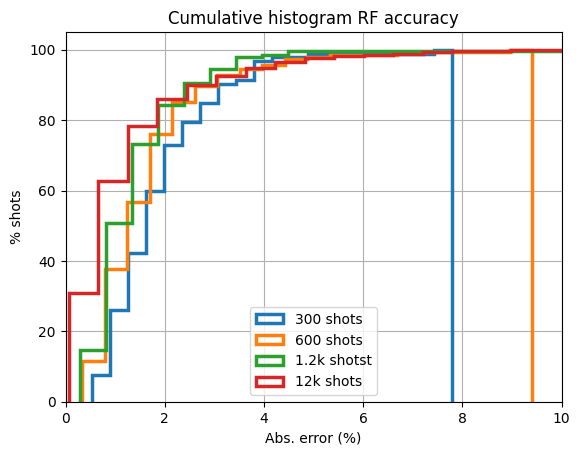

In [68]:
weights_roundtrip_300 = 100*np.ones_like(df_error_roundtrip_300) / len(df_error_roundtrip_300)
weights_roundtrip_600 = 100*np.ones_like(df_error_roundtrip_600) / len(df_error_roundtrip_600)
weights_roundtrip_1200 = 100*np.ones_like(df_error_roundtrip_1200) / len(df_error_roundtrip_1200)
weights_roundtrip_3k = 100*np.ones_like(df_error_roundtrip_3k) / len(df_error_roundtrip_3k)
weights_roundtrip_6k = 100*np.ones_like(df_error_roundtrip_6k) / len(df_error_roundtrip_6k)
weights_roundtrip_12k = 100*np.ones_like(df_error_roundtrip_12k) / len(df_error_roundtrip_12k)
(100*df_error_roundtrip_300).hist(bins=20,weights=weights_roundtrip_300,cumulative=True,histtype="step",linewidth=2.5,label='300 shots')
(100*df_error_roundtrip_600).hist(bins=20,weights=weights_roundtrip_600,cumulative=True,histtype="step",linewidth=2.5,label='600 shots')
(100*df_error_roundtrip_1200).hist(bins=20,weights=weights_roundtrip_1200,cumulative=True,histtype="step",linewidth=2.5,label='1.2k shotst')
#(100*df_error_roundtrip_3k).hist(bins=20,weights=weights_roundtrip_3k,cumulative=True,histtype="step",linewidth=2.5,label='3k shots')
#(100*df_error_roundtrip_6k).hist(bins=20,weights=weights_roundtrip_6k,cumulative=True,histtype="step",linewidth=2.5,label='6k shots')
(100*df_error_roundtrip_12k).hist(bins=20,weights=weights_roundtrip_12k,cumulative=True,histtype="step",linewidth=2.5,label='12k shots')


plt.ylabel('% shots')
plt.xlabel('Abs. error (%)')
plt.title('Cumulative histogram RF accuracy')
plt.xlim(0,10)
plt.legend()
plt.show()